##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [8]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense as Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# pool.close()

In [9]:
FillVar = 'fco2'
FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
             'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
FullModel = ['PPFD_Avg','AirTC_Avg',
             'VPD']
Runs,params = Dense.Params('Test',FillVar,MP=False)

In [10]:
def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))

Time = time.time()
Path = 'Data_Footprints_2018-05-11.csv'

# plt.figure(figsize=(10,10))
def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
#     STD = []
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['K']))):

            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            MSE.append(results[0])
            Y_fill.append(results[1])
            Yval.append(results[2])
            y_val.append(results[3])
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    
    Yval = np.asanyarray(Yval)
    Yval = Yval.mean(axis=0)
    y_val = np.asanyarray(y_val)
    y_val = y_val.mean(axis=0)
    
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    Runs['SE'][i]=MSE.std()/(params['K']**.5)
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

Runs['CI'] = Runs['STD']/params['K']**.5*stats.t.ppf(1-0.05, params['K']-2)

def Curve(x,a,b,c):
    return (a/(b+x)**c)

popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)

print(time.time()-Time)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.447577759347
Finisehed Run  1  MSE:  0.214540525382
Finisehed Run  2  MSE:  0.155695839905
Finisehed Run  3  MSE:  0.143969091954
Finisehed Run  4  MSE:  0.146464726281
Finisehed Run  5  MSE:  0.138445634085
Finisehed Run  6  MSE:  0.137334625719
Finisehed Run  7  MSE:  0.136392231868
221.351478099823


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in power


# The "Optimum" Sized Model

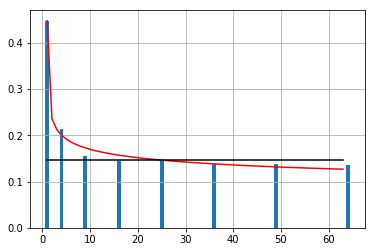

26


In [11]:
fig,ax = plt.subplots()
ax.bar(Runs['N'],Runs['MSE'])

N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Min = Runs.loc[Runs['MSE']==Runs['MSE'].min()]
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
params['N']=N[Fit<Max].min()
plt.grid()
plt.show()
print(params['N'])

# Feature Identification

In [12]:
def Tukeys(Names,Values,Best,Past_Best = None, p = .2):
    Best = list(Best)
    d = {'Model':Names,'MSE':Values}
    Data = pd.DataFrame(data=d)
    posthoc = pairwise_tukeyhsd(
        Data['MSE'], Data['Model'],
        alpha=p)
    c = 0
    for i,val in enumerate(posthoc.groupsunique):
        for j,vayl in enumerate(posthoc.groupsunique[i+1:]): 
            if posthoc.reject[c] == False:
                if vayl == Best[0]:
                    Best.append(val)
                if val == Best[0]:
                    Best.append(vayl)
            c+=1
    return(Best)

In [ ]:
def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print(Models)
    return(Models)

Scores = Runs[['MSE','CI','STD']].reset_index(drop=True)
Scores = (Scores.iloc[0:1])*0
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
Scores['Best'] = 'N'

Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
    Values = []
    Names = []
    for i,model in enumerate(Models):
        level = len(model)
        key = str(level)+'_'+str(i)
        Name = '+'.join(model)
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+Name
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        for mse in MSE:
            Names.append(Name)
            Values.append(mse)
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
        d = {'Model':'+'.join(model),'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Key':key,'Best':'N'}
        score = pd.DataFrame(index=[0],data=d)
        print(model,mean)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]    
    
    Min = Scores.loc[Scores['Level']==level]
    Min = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
    Best = Tukeys(Names,Values,Min)
    Scores.loc[Scores['Model'].isin(Best),'Best']='Y'
    Best = Min
    print(Best)


Level:  1
[['PPFD_Avg'], ['AirTC_Avg'], ['VPD']]
['PPFD_Avg'] 0.152806205094
['AirTC_Avg'] 0.885234812474
['VPD'] 0.754913292956
['PPFD_Avg']
Level:  2
[['PPFD_Avg', 'AirTC_Avg'], ['PPFD_Avg', 'VPD']]
['PPFD_Avg', 'AirTC_Avg'] 0.153709235356
['PPFD_Avg', 'VPD'] 0.147097683166
['PPFD_Avg+VPD']


In [ ]:

def Curve(x,a,b,c):
    return (a/(b+x)**c)

N = Runs['N']
NRuns = Runs*0
NRuns['N']=N
print(NRuns)

model = Best[0].split('+')

for i in NRuns.index:
    try:
        params['T']=NRuns['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=NRuns['N'].iloc[i]
    Results = RunReps(model,params,pool,plot=False)
    MSE = Results[0]
    NRuns['MSE'][i]=MSE.mean()
    NRuns['STD'][i]=MSE.std()
    NRuns['SE'][i]=MSE.std()/(params['K']**.5)
    print('Finisehed Run ',str(i),' MSE: ',MSE.mean())

NRuns['CI'] = NRuns['STD']/params['K']**.5*stats.t.ppf(1-0.05, params['K']-2)

popt, pcov = curve_fit(Curve, NRuns['N'].values, NRuns['MSE'].values)

fig,ax = plt.subplots()
ax.bar(NRuns['N'],NRuns['MSE'])
N = np.arange(Runs['N'].min(),Runs['N'].max())
Fit = Curve(N,*popt)
ax.plot(N,Fit,color='r')
Min = NRuns.loc[NRuns['MSE']==NRuns['MSE'].min()]
Max = (Min['MSE']+Min['SE']).values[0]
ax.plot(N,N*0+Max,color = 'black')
params['N']=N[Fit<Max].min()
plt.show()



level = len(Best)
key = '0_'+str(params['N'])
Name = '+'.join(Best)
NewRow = Scores.iloc[-1].copy()
NewRow['Model'] = 'BestModel: '+Name
Results = RunReps(model,params,pool)
MSE = Results[0]
for mse in MSE:
    Names.append(Name)
    Values.append(mse)
mean,std = MSE.mean(),MSE.std()
CI = std/params['K']**.5*stats.t.ppf(1-0.05, params['K']-1)
d = {'Model':'+'.join(model),'MSE':mean,'STD':std,'Level':level,
     'CI':CI,'Key':key,'Best':'N'}
score = pd.DataFrame(index=[0],data=d)
print(model,mean)
Scores = Scores.append(score,ignore_index=True)
ModelRuns['BestModel: '+'+'.join(model)] = Results[1] 


print(params['N'])
# print(time.time()-Time)


Scores.to_csv('GapFillingSummary'+FillVar+'_Test.csv')
ModelNRuns.to_csv('GapFilled'+FillVar+'_Test.csv')

    N  MSE  STD   CI   SE
0   1  0.0  0.0  0.0  0.0
1   4  0.0  0.0  0.0  0.0
2   9  0.0  0.0  0.0  0.0
3  16  0.0  0.0  0.0  0.0
4  25  0.0  0.0  0.0  0.0
5  36  0.0  0.0  0.0  0.0
6  49  0.0  0.0  0.0  0.0
7  64  0.0  0.0  0.0  0.0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0  MSE:  0.374306105031
Finisehed Run  1  MSE:  0.205731229305
Finisehed Run  2  MSE:  0.156696733509
Finisehed Run  3  MSE:  0.14801878713
Finisehed Run  4  MSE:  0.148756144013


In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)

In [ ]:
plt.plot(N,2/(N+10)**1.75)
plt.show()